# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
import numpy as np
import os
import scipy
from cv2 import imread,resize
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras import backend as k

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
!nvidia-smi

Tue Mar 30 15:08:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.09       Driver Version: 461.09       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 165... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P8     8W /  N/A |    134MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open(r'C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def normalize_image(img):
    normalized_image= (img - np.mean(img))/(np.std(img))
    return normalized_image


def generator(source_path, folder_list, batch_size,frames,im_height,im_width):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(frames)]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames,im_height,im_width,3)) # frames is the number of images you use for each video, (im_height,im_width) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(im_height,im_width))

                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = normalize_image(image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize_image(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize_image(image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,frames,im_height,im_width,3)) # frames is the number of images you use for each video, (im_height,im_width) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(im_height,im_width))
                    
                    batch_data[folder,idx,:,:,0] =  normalize_image(temp[:,:,0])
                    batch_data[folder,idx,:,:,1] =  normalize_image(temp[:,:,1])
                    batch_data[folder,idx,:,:,2] =  normalize_image(temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = r'C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train'
val_path = r'C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
# Importing all packages

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras import layers
from keras.layers import Dense, Conv1D, Input, MaxPooling1D, Flatten, Dropout, LSTM , SimpleRNN
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.applications import mobilenet
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [8]:
def train_model(model,batch_size,train_generator,val_generator,num_epochs,augment_data=False):

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        callbacks_list = [checkpoint, LR]
        
#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences//batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
            
        optimiser = 'adam'            #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


In [9]:
def visual(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'],label='Training Loss')
    plt.plot(history['val_loss'],label='Validation Loss')
    plt.legend(['loss','val loss'])
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(history['val_categorical_accuracy'],label='Validation Accuracy')
    plt.legend(['train accuracy','val accuracy'])
    plt.title('Training and Validation Accuracy')
    plt.show()

## Model no 1:

In [9]:
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =50    # no of batches
frames = 30       # no of frames
im_height = 120   # height of the image
im_width = 120    # width of the image
epochs=10     # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [10]:
# Now create a Sequential model object and add layers to it.

input_shape = (51,frames,im_height,im_width,3)


Conv3d1 = Sequential([
                    # tf.random.normal(input_shape),
                    Conv3D(8,kernel_size=(3,3,3),activation='relu',padding="same", input_shape = input_shape[1:] ),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Conv3D(16,kernel_size=(3,3,3),activation='relu',padding="same"),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Conv3D(32,kernel_size=(1,3,3),activation='relu',padding="same"),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Conv3D(64,kernel_size=(1,3,3),activation='relu',padding="same"),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Flatten(),
                    Dense(1000,activation = 'relu'),
                    Dense(500,activation = 'relu'),
                    Dense(5,activation = 'softmax')
])

In [11]:
# Summary and number of parameters to be trained in the model.

print (Conv3d1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 8)   656       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 32)     4640      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 15, 15, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 15, 15, 64)     1

In [12]:
# Let us fit this model using train_model function

Conv3d1_hist=train_model(Conv3d1,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 50
Epoch 1/10
14/14 [==============================] - 352s 25s/step - loss: 2.2236 - categorical_accuracy: 0.1653 - val_loss: 1.5908 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.59078, saving model to model_init_2021-03-2910_41_49.163998\model-00001-1.92875-0.19155-1.59078-0.23000.h5
Epoch 2/10
14/14 [==============================] - 108s 8s/step - loss: 1.5806 - categorical_accuracy: 0.2713 - val_loss: 1.6047 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 1.59078
Epoch 3/10
14/14 [==============================] - 108s 8s/step - loss: 1.5981 - categorical_accuracy: 0.3251 - val_loss: 1.5961 - val_categorical_accuracy: 0.3600

Epoch 00003: val_loss did not improve from 1.59078
Epoch 4/10
14/14 [==============================] - 108s 8s/step - loss: 1.5891 - categorical_accuracy: 0.3690 - val_loss: 1.5317 - val

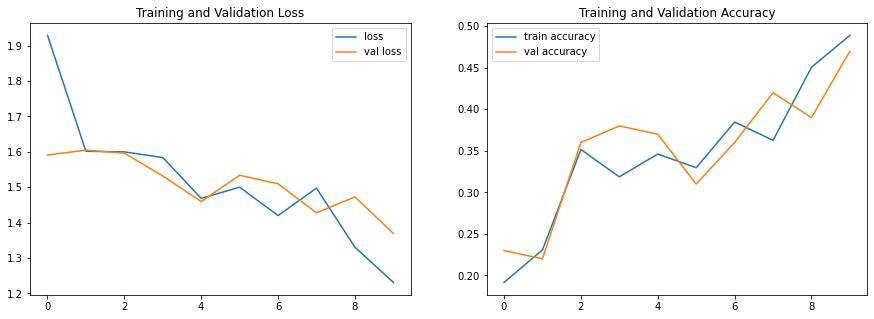

In [13]:
visual(Conv3d1_hist.history)

 We can see that model is underfitting with only 46% accuracy.

## Model number 2:

In [14]:
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =30    # no of batches
frames = 30       # no of frames
im_height = 120   # height of the image
im_width = 120    # width of the image
epochs=15     # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [15]:
# Now let us make some changes to Conv3d2 structure and name it as Conv3d2.

input_shape = (51,frames,im_height,im_width,3)


Conv3d2 = Sequential([
                
                    Conv3D(16,kernel_size=(3,3,3),activation='relu',padding="same", input_shape = input_shape[1:] ),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(16,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(16,kernel_size=(1,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(16,kernel_size=(1,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Flatten(),
    
                    Dense(500,activation = 'relu'),
                    Dense(500,activation='relu'),
    
                    Dense(5,activation = 'softmax')
])

In [16]:
print(Conv3d2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 16)    6928      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 7, 30, 30, 16)    

In [17]:
# Let us fit this model using train_model function

Conv3d2_hist=train_model(Conv3d2,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 2.2161 - categorical_accuracy: 0.2742 Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 637s 28s/step - loss: 2.2010 - categorical_accuracy: 0.2770 - val_loss: 1.5742 - val_categorical_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 1.57424, saving model to model_init_2021-03-2911_03_54.449572\model-00001-1.85310-0.34238-1.57424-0.30000.h5
Epoch 2/15
23/23 [==============================] - 77s 3s/step - loss: 1.0030 - categorical_accuracy: 0.6524 - val_loss: 1.7994 - val_categorical_accuracy: 0.1750

Epoch 00002: val_loss did not improve from 1.57424
Epoch 3/15
23/23 [==============================] - 77s 3s/step - loss: 1.6637 - categorical_accuracy: 0.3647 - val_loss: 1.5497

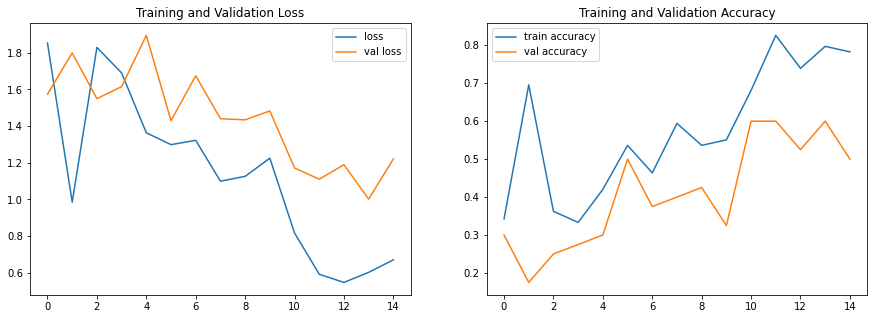

In [18]:
visual(Conv3d2_hist.history)

 More than 30% difference in Training and validation set accuracies. Clearly model is overfitting.

## Model no 3:

In [23]:
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =30    # no of batches
frames = 30       # no of frames
im_height = 120   # height of the image
im_width = 120    # width of the image
epochs=15     # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [24]:
# Now let us make some changes to Conv3d2 structure and name it as Conv3d2.

input_shape = (51,frames,im_height,im_width,3)


Conv3d3 = Sequential([
                
                    Conv3D(16,kernel_size=(3,3,3),activation='relu',padding="same", input_shape = input_shape[1:] ),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(16,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(16,kernel_size=(1,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(16,kernel_size=(1,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Flatten(),
    
                    Dense(500,activation = 'relu'),
                    Dropout(0.25),
    
                    Dense(500,activation='relu'),
                    Dropout(0.25),
    
                    Dense(5,activation = 'softmax')
])

In [25]:
print(Conv3d3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 60, 60, 16)    6928      
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 7, 30, 30, 16)    

In [26]:
# Let us fit this model using train_model function

Conv3d3_hist=train_model(Conv3d3,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.9691 - categorical_accuracy: 0.3146 Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 642s 28s/step - loss: 1.9598 - categorical_accuracy: 0.3161 - val_loss: 1.5303 - val_categorical_accuracy: 0.3400

Epoch 00001: val_loss improved from inf to 1.53035, saving model to model_init_2021-03-2911_33_44.860013\model-00001-1.74549-0.34992-1.53035-0.34000.h5
Epoch 2/15
23/23 [==============================] - 79s 3s/step - loss: 1.3607 - categorical_accuracy: 0.6048 - val_loss: 2.0504 - val_categorical_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 1.53035
Epoch 3/15
23/23 [==============================] - 78s 3s/step - loss: 1.5639 - categorical_accuracy: 0.5550 - val_loss: 1.7315

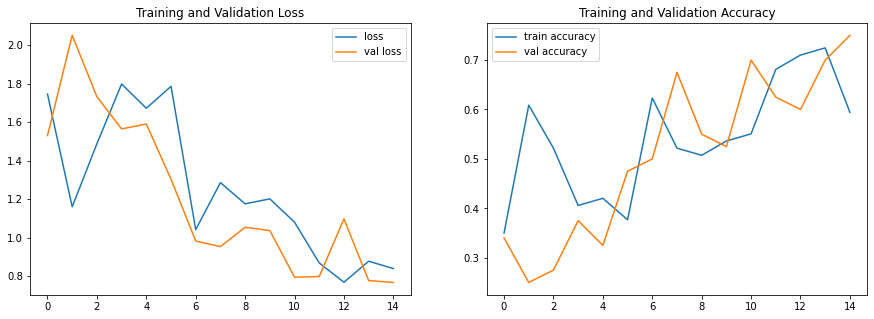

In [27]:
visual(Conv3d3_hist.history)

We can see that accuracies of training and validation set are improved but there still is a huge gap between them suggesting overfitting,

# Model 4:

In [28]:
# Now we use Drop out method to tackle overfitting.

In [29]:
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =20    # no of batches
frames = 30       # no of frames
im_height = 120   # height of the image
im_width = 120    # width of the image
epochs=15         # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [30]:
# Now let us make some changes to Conv3d3 structure and name it as Conv3d2.

input_shape = (51,frames,im_height,im_width,3)


Conv3d4 = Sequential([
                
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same", input_shape = input_shape[1:] ),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Flatten(),
    
                    Dense(128,activation = 'relu'),
                    Dense(128,activation='relu'),
                    Dropout(0.15), 
    
    
                    Dense(5,activation = 'softmax')
])

In [31]:
print(Conv3d4.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 15, 60, 60, 32)    27680     
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 7, 30, 30, 32)    

In [32]:
# Let us fit this model using train_model function

Conv3d4_hist=train_model(Conv3d4,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - 1235s 36s/step - loss: 1.9407 - categorical_accuracy: 0.2798 - val_loss: 1.4337 - val_categorical_accuracy: 0.3800

Epoch 00001: val_loss improved from inf to 1.43367, saving model to model_init_2021-03-2912_02_31.182950\model-00001-1.67727-0.33183-1.43367-0.38000.h5
Epoch 2/15
34/34 [==============================] - 213s 6s/step - loss: 1.3300 - categorical_accuracy: 0.4842 - val_loss: 1.8293 - val_categorical_accuracy: 0.3100

Epoch 00002: val_loss did not improve from 1.43367
Epoch 3/15
34/34 [==============================] - 212s 6s/step - loss: 1.6078 - categorical_accuracy: 0.3523 - val_loss: 2.5790 - val_categorical_accuracy: 0.3400

Epoch 00003: val_loss did not improve from 1.43367
Epoch 4/15
34/34 [==============================] - 211s 6s/step - loss: 1.6828 - categorical_accuracy: 0.3578 - val_loss: 1.6458 - va

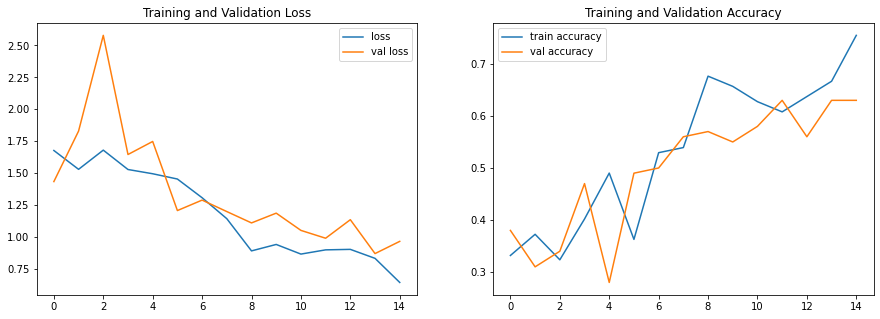

In [33]:
visual(Conv3d4_hist.history)

training accuracy : 74.15% and validation accuracy 63% . Model is  overfitting so lets try to increase accuracy.

# Model 5:

In [10]:
# Here we try increasing the size of the image.
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =20    # no of batches
frames = 30       # no of frames
im_height = 160   # height of the image
im_width = 160    # width of the image
epochs=15         # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [11]:
# Now let us make some changes to Conv3d3 structure and name it as Conv3d2.

input_shape = (51,frames,im_height,im_width,3)


Conv3d5 = Sequential([
                
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same", input_shape = input_shape[1:] ),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Flatten(),
    
                    Dense(128,activation = 'relu'),
                    Dense(128,activation='relu'),
                    Dropout(0.15), 
    
    
                    Dense(5,activation = 'softmax')
])

In [12]:
print(Conv3d5.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 40, 40, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 40, 40, 32)     2

In [13]:
# Let us fit this model using train_model function

Conv3d5_hist=train_model(Conv3d5,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - 2200s 65s/step - loss: 2.2895 - categorical_accuracy: 0.2841 - val_loss: 1.5433 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 1.54326, saving model to model_init_2021-03-2914_32_33.951592\model-00001-1.80689-0.34842-1.54326-0.36000.h5
Epoch 2/15
34/34 [==============================] - 378s 11s/step - loss: 1.1752 - categorical_accuracy: 0.4121 - val_loss: 2.2023 - val_categorical_accuracy: 0.3400

Epoch 00002: val_loss did not improve from 1.54326
Epoch 3/15
34/34 [==============================] - 369s 11s/step - loss: 1.8950 - categorical_accuracy: 0.3828 - val_loss: 1.8047 - val_categorical_accuracy: 0.3600

Epoch 00003: val_loss did not improve from 1.54326
Epoch 4/15
34/34 [==============================] - 370s 11s/step - loss: 1.3160 - categorical_accuracy: 0.5896 - val_loss: 1.9673 -

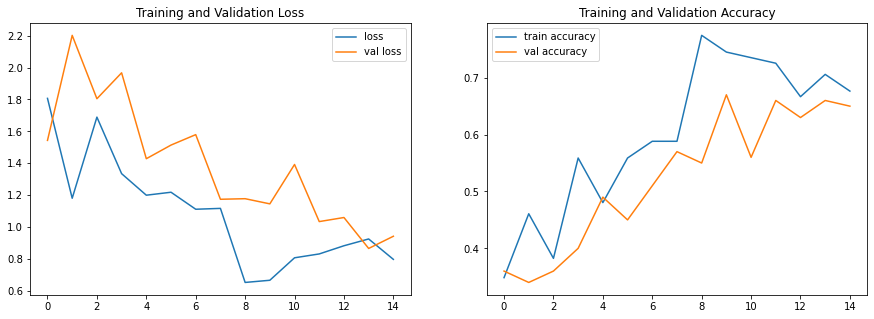

In [14]:
visual(Conv3d5_hist.history)

As we can see accuracy of the model on training set is 61% and 65% accuracy on validation set.

## Model 6:

In [10]:
# Now we try decreasing the image size
# Here we try increasing the size of the image.
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =20    # no of batches
frames = 30       # no of frames
im_height = 100   # height of the image
im_width = 100    # width of the image
epochs=15         # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [11]:
# Now let us make some changes to Conv3d3 structure and name it as Conv3d2.

input_shape = (51,frames,im_height,im_width,3)


Conv3d6 = Sequential([
                
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same", input_shape = input_shape[1:] ),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Flatten(),
    
                    Dense(128,activation = 'relu'),
                    Dense(128,activation='relu'),
                    Dropout(0.15), 
    
    
                    Dense(5,activation = 'softmax')
])

In [12]:
print(Conv3d6.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 100, 100, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 50, 50, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 50, 50, 32)    27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 25, 25, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 25, 25, 32)     2

In [13]:
# Let us fit this model using train_model function

Conv3d6_hist=train_model(Conv3d6,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - 950s 28s/step - loss: 2.0938 - categorical_accuracy: 0.2630 - val_loss: 1.5860 - val_categorical_accuracy: 0.3700

Epoch 00001: val_loss improved from inf to 1.58600, saving model to model_init_2021-03-2921_18_22.218057\model-00001-1.68750-0.33937-1.58600-0.37000.h5
Epoch 2/15
34/34 [==============================] - 169s 5s/step - loss: 1.1886 - categorical_accuracy: 0.4928 - val_loss: 1.4315 - val_categorical_accuracy: 0.3500

Epoch 00002: val_loss improved from 1.58600 to 1.43153, saving model to model_init_2021-03-2921_18_22.218057\model-00002-1.30774-0.43137-1.43153-0.35000.h5
Epoch 3/15
34/34 [==============================] - 168s 5s/step - loss: 1.5372 - categorical_accuracy: 0.3968 - val_loss: 1.9820 - val_categorical_accuracy: 0.3300

Epoch 00003: val_loss did not improve from 1.43153
Epoch 4/15
34/34 [============

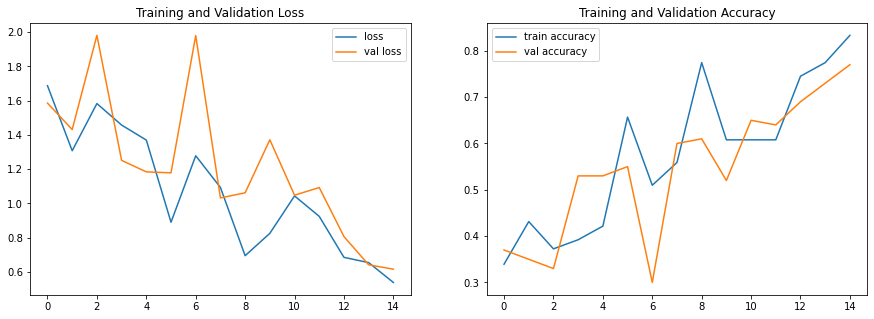

In [14]:
visual(Conv3d6_hist.history)

we can see that training accuracy is around 78% but validation accuracy is 77%.

## Model 7:

In [20]:
# Now we try to counter overfitting by increasing dropouts.

# Now we try decreasing the image size
# Here we try increasing the size of the image.
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =20    # no of batches
frames = 30       # no of frames
im_height = 100   # height of the image
im_width = 100  # width of the image
epochs=15         # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [21]:
# Now let us make some changes to Conv3d3 structure and name it as Conv3d2.

input_shape = (51,frames,im_height,im_width,3)


Conv3d7 = Sequential([
                
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same", input_shape = input_shape[1:] ),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
    
                    Flatten(),
    
                    Dense(128,activation = 'relu'),
                    Dropout(0.15),
    
                    Dense(128,activation='relu'),
                    Dropout(0.15), 
    
    
                    Dense(5,activation = 'softmax')
])

In [22]:
print(Conv3d7.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 100, 100, 32)  128       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 50, 50, 32)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 50, 50, 32)    27680     
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 7, 25, 25, 32)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 7, 25, 25, 32)    

In [23]:
# Let us fit this model using train_model function

Conv3d7_hist=train_model(Conv3d7,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - 843s 25s/step - loss: 2.0844 - categorical_accuracy: 0.2643 - val_loss: 1.5039 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 1.50393, saving model to model_init_2021-03-2917_24_45.319875\model-00001-1.78881-0.29261-1.50393-0.33000.h5
Epoch 2/15
34/34 [==============================] - 144s 4s/step - loss: 1.4402 - categorical_accuracy: 0.3770 - val_loss: 1.5498 - val_categorical_accuracy: 0.2700

Epoch 00002: val_loss did not improve from 1.50393
Epoch 3/15
34/34 [==============================] - 522s 16s/step - loss: 1.4098 - categorical_accuracy: 0.3771 - val_loss: 1.8788 - val_categorical_accuracy: 0.3400

Epoch 00003: val_loss did not improve from 1.50393
Epoch 4/15
34/34 [==============================] - 686s 20s/step - loss: 1.5767 - categorical_accuracy: 0.3487 - val_loss: 1.6424 - v

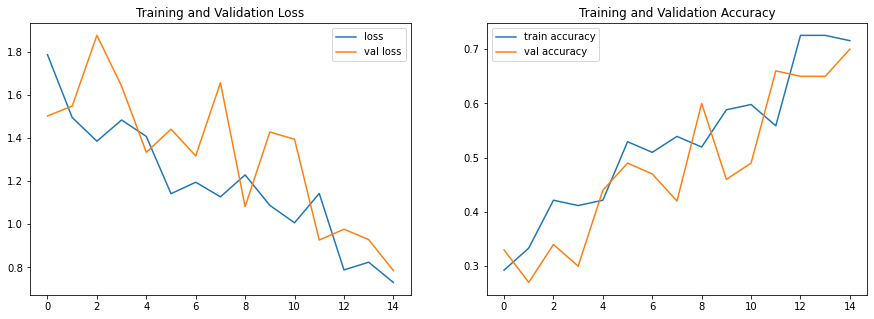

In [24]:
visual(Conv3d7_hist.history)

We can see that the training and validation accuracies are around 66% and 70%.

## Model 8 (CNN+LSTM):

In [25]:
# Now we try to counter overfitting by increasing dropouts.

# Now we try decreasing the image size
# Here we try increasing the size of the image.
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =20    # no of batches
frames = 30       # no of frames
im_height = 100   # height of the image
im_width = 100  # width of the image
epochs=15         # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [26]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape=input_shape[1:]))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.15))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(5, activation='softmax'))

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 50, 50, 32)    9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 25, 25, 32)   

In [28]:
# Let us fit this model using train_model function

model=train_model(model,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - 190s 6s/step - loss: 1.6580 - categorical_accuracy: 0.2102 - val_loss: 1.5596 - val_categorical_accuracy: 0.3800

Epoch 00001: val_loss improved from inf to 1.55960, saving model to model_init_2021-03-2918_42_21.565435\model-00001-1.61993-0.23379-1.55960-0.38000.h5
Epoch 2/15
34/34 [==============================] - 37s 1s/step - loss: 1.5130 - categorical_accuracy: 0.3682 - val_loss: 1.6014 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss did not improve from 1.55960
Epoch 3/15
34/34 [==============================] - 37s 1s/step - loss: 1.5100 - categorical_accuracy: 0.3840 - val_loss: 1.5794 - val_categorical_accuracy: 0.2700

Epoch 00003: val_loss did not improve from 1.55960
Epoch 4/15
34/34 [==============================] - 36s 1s/step - loss: 1.4488 - categorical_accuracy: 0.3415 - val_loss: 1.4355 - val_cat

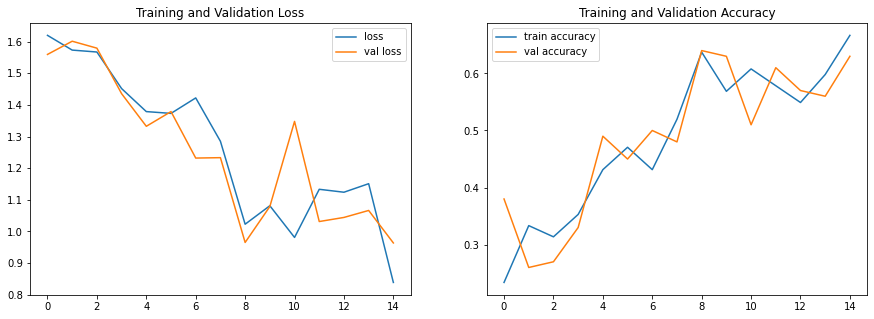

In [29]:
visual(model.history)

As we can see that model has 72% accuracy in training set and 63% accuracy in validation set so it is overfitting.

# Model 9:

In [30]:
# Now we try to counter overfitting by increasing dropouts.

# Now we try decreasing the image size
# Here we try increasing the size of the image.
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =20    # no of batches
frames = 30       # no of frames
im_height = 100   # height of the image
im_width = 100  # width of the image
epochs=20         # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [31]:
model2 = Sequential()

model2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape=input_shape[1:]))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))


model2.add(TimeDistributed(Flatten()))

model2.add(LSTM(256))
model2.add(Dropout(0.15))

model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.15))

model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.15))

model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.15))

model2.add(Dense(5, activation='softmax'))

In [32]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 30, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 50, 50, 32)    9248      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 25, 25, 32)   

In [33]:
# Let us fit this model using train_model function

model2=train_model(model2,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 192s 6s/step - loss: 1.6278 - categorical_accuracy: 0.2379 - val_loss: 1.4696 - val_categorical_accuracy: 0.4100

Epoch 00001: val_loss improved from inf to 1.46964, saving model to model_init_2021-03-2918_54_19.561904\model-00001-1.58793-0.27903-1.46964-0.41000.h5
Epoch 2/20
34/34 [==============================] - 37s 1s/step - loss: 1.4201 - categorical_accuracy: 0.3929 - val_loss: 1.5426 - val_categorical_accuracy: 0.2400

Epoch 00002: val_loss did not improve from 1.46964
Epoch 3/20
34/34 [==============================] - 37s 1s/step - loss: 1.3781 - categorical_accuracy: 0.4203 - val_loss: 1.3830 - val_categorical_accuracy: 0.4500

Epoch 00003: val_loss improved from 1.46964 to 1.38303, saving model to model_init_2021-03-2918_54_19.561904\model-00003-1.46462-0.38235-1.38303-0.45000.h5
Epoch 4/20
34/34 [===============

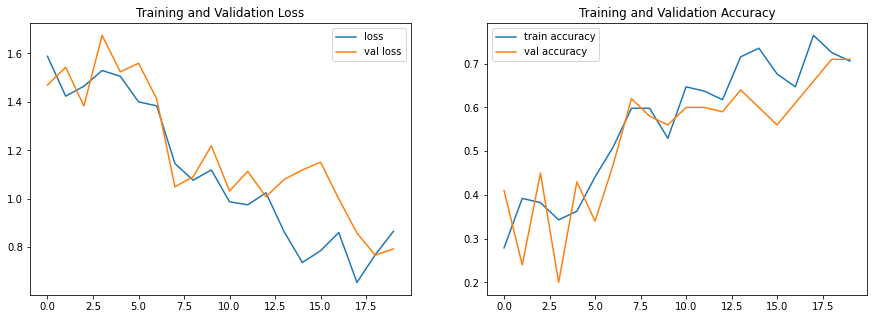

In [34]:
visual(model2.history)

We can see that accuracy is increased from the last model but it is still not satisfying.

## Model 10

In [35]:
# Now we try to counter overfitting by increasing dropouts.

# Now we try decreasing the image size
# Here we try increasing the size of the image.
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =30    # size of each batch
frames = 30    # no of frames
im_height = 100   # height of the image
im_width = 100  # width of the image
epochs=20        # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [36]:
input_shape=[batch_size,frames,im_height,im_width,3]

model3 = Sequential()

model3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'),input_shape=input_shape[1:]))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))


model3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Flatten()))

model3.add(Dense(128,activation='relu'))
model3.add(Dropout(0.15))

model3.add(Dense(128,activation='relu'))
model3.add(Dropout(0.15))

model3.add(LSTM(1024))
model3.add(Dropout(0.15))

model3.add(Dense(5, activation='softmax'))

In [37]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 30, 100, 100, 64)  1792      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 30, 100, 100, 64)  256       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 30, 50, 50, 64)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 30, 50, 50, 64)    36928     
_________________________________________________________________
time_distributed_30 (TimeDis (None, 30, 50, 50, 64)    256       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 30, 25, 25, 64)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 30, 25, 25, 64)   

In [38]:
# Let us fit this model using train_model function

model3=train_model(model3,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.2240 - categorical_accuracy: 0.2550 Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 399s 17s/step - loss: 2.2079 - categorical_accuracy: 0.2576 - val_loss: 1.4849 - val_categorical_accuracy: 0.3800

Epoch 00001: val_loss improved from inf to 1.48487, saving model to model_init_2021-03-2919_09_23.735016\model-00001-1.83720-0.31674-1.48487-0.38000.h5
Epoch 2/20
23/23 [==============================] - 46s 2s/step - loss: 1.3577 - categorical_accuracy: 0.5735 - val_loss: 1.5293 - val_categorical_accuracy: 0.3500

Epoch 00002: val_loss did not improve from 1.48487
Epoch 3/20
23/23 [==============================] - 44s 2s/step - loss: 1.3726 - categorical_accuracy: 0.4094 - val_loss: 1.7566

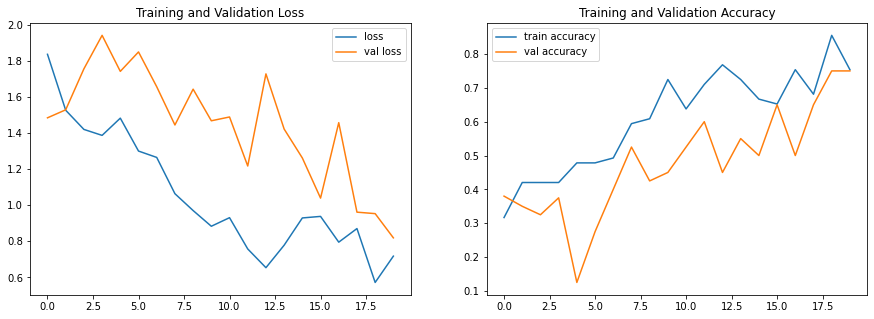

In [39]:
visual(model3.history)

Model is not overfitting and has accuracy over 72 and 75 in training and validation sets.

## Model 11

In [22]:
# Now we try to counter overfitting by increasing dropouts.

# Now we try decreasing the image size
# Here we try increasing the size of the image.
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =30    # size of each batch
frames = 30    # no of frames
im_height = 100   # height of the image
im_width = 100  # width of the image
epochs=20        # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [23]:
input_shape=[batch_size,frames,im_height,im_width,3]

model4 = Sequential()

model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'),input_shape=input_shape[1:]))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))


model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Flatten()))

model4.add(Dense(128,activation='relu'))
model4.add(Dropout(0.20))

model4.add(LSTM(512))
model4.add(Dropout(0.20))

model4.add(Dense(5, activation='softmax'))

In [25]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_42 (TimeDis (None, 30, 100, 100, 64)  1792      
_________________________________________________________________
time_distributed_43 (TimeDis (None, 30, 100, 100, 64)  256       
_________________________________________________________________
time_distributed_44 (TimeDis (None, 30, 50, 50, 64)    0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 30, 50, 50, 64)    36928     
_________________________________________________________________
time_distributed_46 (TimeDis (None, 30, 50, 50, 64)    256       
_________________________________________________________________
time_distributed_47 (TimeDis (None, 30, 25, 25, 64)    0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 30, 25, 25, 64)   

In [26]:
# Let us fit this model using train_model function

model4=train_model(model4,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.5703 - categorical_accuracy: 0.3212 Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 396s 17s/step - loss: 1.5642 - categorical_accuracy: 0.3245 - val_loss: 1.3345 - val_categorical_accuracy: 0.4400

Epoch 00001: val_loss improved from inf to 1.33448, saving model to model_init_2021-03-2815_58_13.401169\model-00001-1.42419-0.40121-1.33448-0.44000.h5
Epoch 2/20
23/23 [==============================] - 46s 2s/step - loss: 1.3575 - categorical_accuracy: 0.4028 - val_loss: 1.8571 - val_categorical_accuracy: 0.2750

Epoch 00002: val_loss did not improve from 1.33448
Epoch 3/20
23/23 [==============================] - 43s 2s/step - loss: 1.4995 - categorical_accuracy: 0.4641 - val_loss: 1.5321

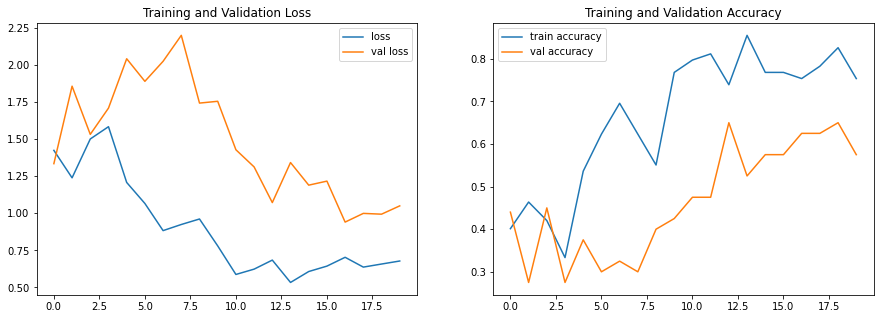

In [27]:
visual(model4.history)

Model is still overfitting...

## Model 12(GRU):

In [49]:
# Now we try to counter overfitting by increasing dropouts.

# Now we try decreasing the image size
# Here we try increasing the size of the image.
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =20    # size of each batch
frames = 30    # no of frames
im_height =100   # height of the image
im_width = 100  # width of the image
epochs=20        # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [50]:
input_shape=[batch_size,frames,im_height,im_width,3]

model5 = Sequential()

model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'),input_shape=input_shape[1:]))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))


model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Flatten()))

model5.add(GRU(256))
model5.add(Dropout(0.25))

model5.add(Dense(256,activation='relu'))
model5.add(Dropout(0.25))

model5.add(Dense(256,activation='relu'))
model5.add(Dropout(0.25))

model5.add(Dense(5, activation='softmax'))

In [51]:
model5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_110 (TimeDi (None, 30, 100, 100, 64)  1792      
_________________________________________________________________
time_distributed_111 (TimeDi (None, 30, 100, 100, 64)  256       
_________________________________________________________________
time_distributed_112 (TimeDi (None, 30, 50, 50, 64)    0         
_________________________________________________________________
time_distributed_113 (TimeDi (None, 30, 50, 50, 64)    36928     
_________________________________________________________________
time_distributed_114 (TimeDi (None, 30, 50, 50, 64)    256       
_________________________________________________________________
time_distributed_115 (TimeDi (None, 30, 25, 25, 64)    0         
_________________________________________________________________
time_distributed_116 (TimeDi (None, 30, 25, 25, 64)   

In [52]:
# Let us fit this model using train_model function

model5=train_model(model5,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 392s 11s/step - loss: 1.6546 - categorical_accuracy: 0.2753 - val_loss: 1.4703 - val_categorical_accuracy: 0.3500

Epoch 00001: val_loss improved from inf to 1.47026, saving model to model_init_2021-03-2821_11_47.750589\model-00001-1.58085-0.32881-1.47026-0.35000.h5
Epoch 2/20
34/34 [==============================] - 69s 2s/step - loss: 1.1423 - categorical_accuracy: 0.5822 - val_loss: 2.2657 - val_categorical_accuracy: 0.2800

Epoch 00002: val_loss did not improve from 1.47026
Epoch 3/20
34/34 [==============================] - 70s 2s/step - loss: 1.3669 - categorical_accuracy: 0.3900 - val_loss: 2.4021 - val_categorical_accuracy: 0.3200

Epoch 00003: val_loss did not improve from 1.47026
Epoch 4/20
34/34 [==============================] - 68s 2s/step - loss: 1.4158 - categorical_accuracy: 0.4331 - val_loss: 2.4828 - val_ca

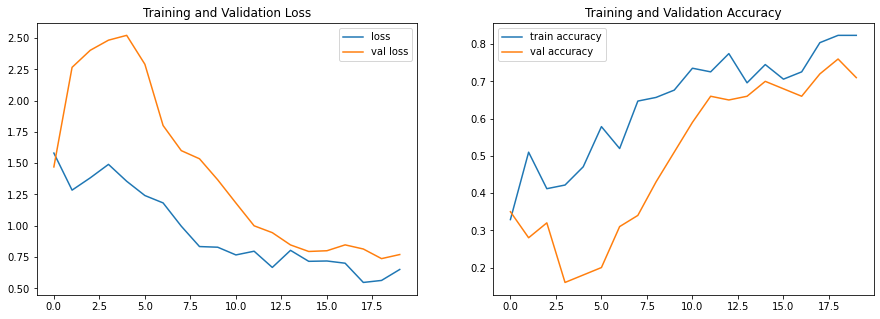

In [53]:
visual(model5.history)

we can see that model is still overfitting.

## Model 13 (Transfer learning)

In [14]:
# Now we try to counter overfitting by increasing dropouts.

# Now we try decreasing the image size
# Here we try increasing the size of the image.
# Let us define hyperparameters of this model and create the `train_generator` and the `val_generator`
# which will be used in `.fit_generator`.

# Hyperparameters being used in this model

batch_size =5    # size of each batch
frames = 16    # no of frames
im_height =120   # height of the image
im_width = 120  # width of the image
epochs=20        # no of epochs



# generate train data and validation data using Generator function.

train_generator = generator(train_path, train_doc, batch_size,frames,im_height,im_width)
val_generator = generator(val_path, val_doc, batch_size,frames,im_height,im_width)

In [15]:
input_shape=[batch_size,frames,im_height,im_width,3]

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model6 = Sequential()
        
model6.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape[1:]))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2),padding='same'))) 
      
model6.add(TimeDistributed(Flatten()))

model6.add(LSTM(128))
model6.add(Dropout(0.25))

model6.add(Dense(128,activation='relu'))
model6.add(Dropout(0.25))
           
model6.add(Dense(5, activation='softmax'))

In [16]:
model6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 4096)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               2163200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [17]:
# Let us fit this model using train_model function

model6=train_model(model6,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - 372s 3s/step - loss: 1.4322 - categorical_accuracy: 0.3821 - val_loss: 0.8447 - val_categorical_accuracy: 0.6900

Epoch 00001: val_loss improved from inf to 0.84465, saving model to model_init_2021-03-2822_42_14.923632\model-00001-1.19353-0.51584-0.84465-0.69000.h5
Epoch 2/20
133/133 [==============================] - 214s 2s/step - loss: 1.0606 - categorical_accuracy: 0.5726 - val_loss: 1.0321 - val_categorical_accuracy: 0.6000

Epoch 00002: val_loss did not improve from 0.84465
Epoch 3/20
133/133 [==============================] - 220s 2s/step - loss: 1.0054 - categorical_accuracy: 0.6407 - val_loss: 1.4598 - val_categorical_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.84465
Epoch 4/20
133/133 [==============================] - 215s 2s/step - loss: 1.0822 - categorical_accuracy: 0.6174 - val_loss: 0.8312

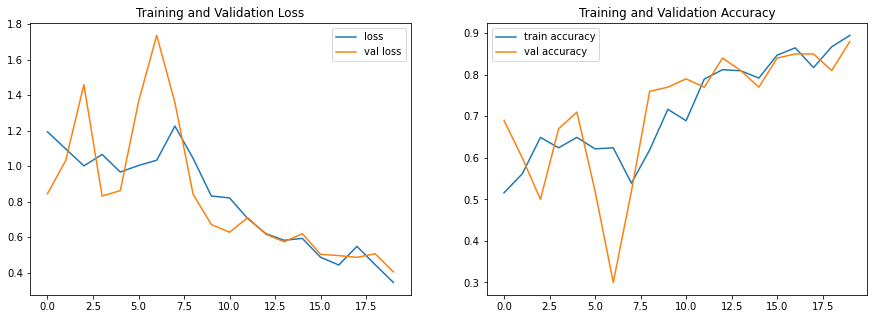

In [18]:
visual(model6.history)

We can see that model has 89% accuracy in training set and 88% accuracy in validation set but it has too manany parameters(around 54,00,000)

This is the model with the best accuracy for both training and validation set but it is exceeding 60 MB in size.

## Model

In [14]:
import time
from keras.models import load_model
model = load_model('model-00015-0.22577-0.93137-0.36049-0.88000.h5')

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 30, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 100, 100, 32)  128       
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 50, 50, 32)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 50, 50, 32)    27680     
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 7, 25, 25, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 7, 25, 25, 32)    

This model has around 93% accuracy on training set and 88% on validation set and also it has fewer parameters 2.50 Lakhs when compared to other models.So it has a smaller size of 3mb.

In [16]:
# Let us fit this model using train_model function

model=train_model(model,batch_size,train_generator,val_generator,epochs)

Source path =  C:\Users\mybes\Documents\upgrad\5.Deep learning\RNN project\Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - 858s 25s/step - loss: 0.2147 - categorical_accuracy: 0.9309 - val_loss: 0.6144 - val_categorical_accuracy: 0.8400

Epoch 00001: val_loss improved from inf to 0.61442, saving model to model_init_2021-03-3015_09_35.739210\model-00001-0.21620-0.92760-0.61442-0.84000.h5
Epoch 2/15
34/34 [==============================] - 148s 4s/step - loss: 0.1419 - categorical_accuracy: 0.9379 - val_loss: 2.7266 - val_categorical_accuracy: 0.5300

Epoch 00002: val_loss did not improve from 0.61442
Epoch 3/15
34/34 [==============================] - 149s 4s/step - loss: 1.3499 - categorical_accuracy: 0.6275 - val_loss: 1.2218 - val_categorical_accuracy: 0.6300

Epoch 00003: val_loss did not improve from 0.61442
Epoch 4/15
34/34 [==============================] - 148s 4s/step - loss: 0.8255 - categorical_accuracy: 0.7388 - val_loss: 0.9560 - val

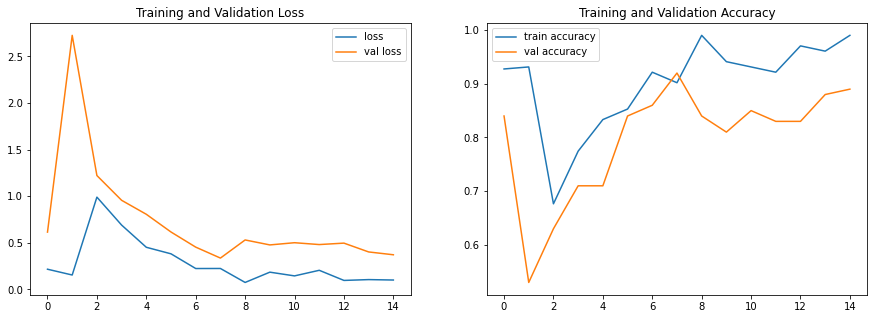

In [17]:
visual(model.history)